In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
import prodimopy.plot as pplot
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.signal import correlate, fftconvolve
from scipy.optimize import minimize

In [3]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def add_noise(flux, SNR):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise


In [4]:
cmap = mpl.colormaps.get_cmap('tab20')

In [5]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [6]:
data = []
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)

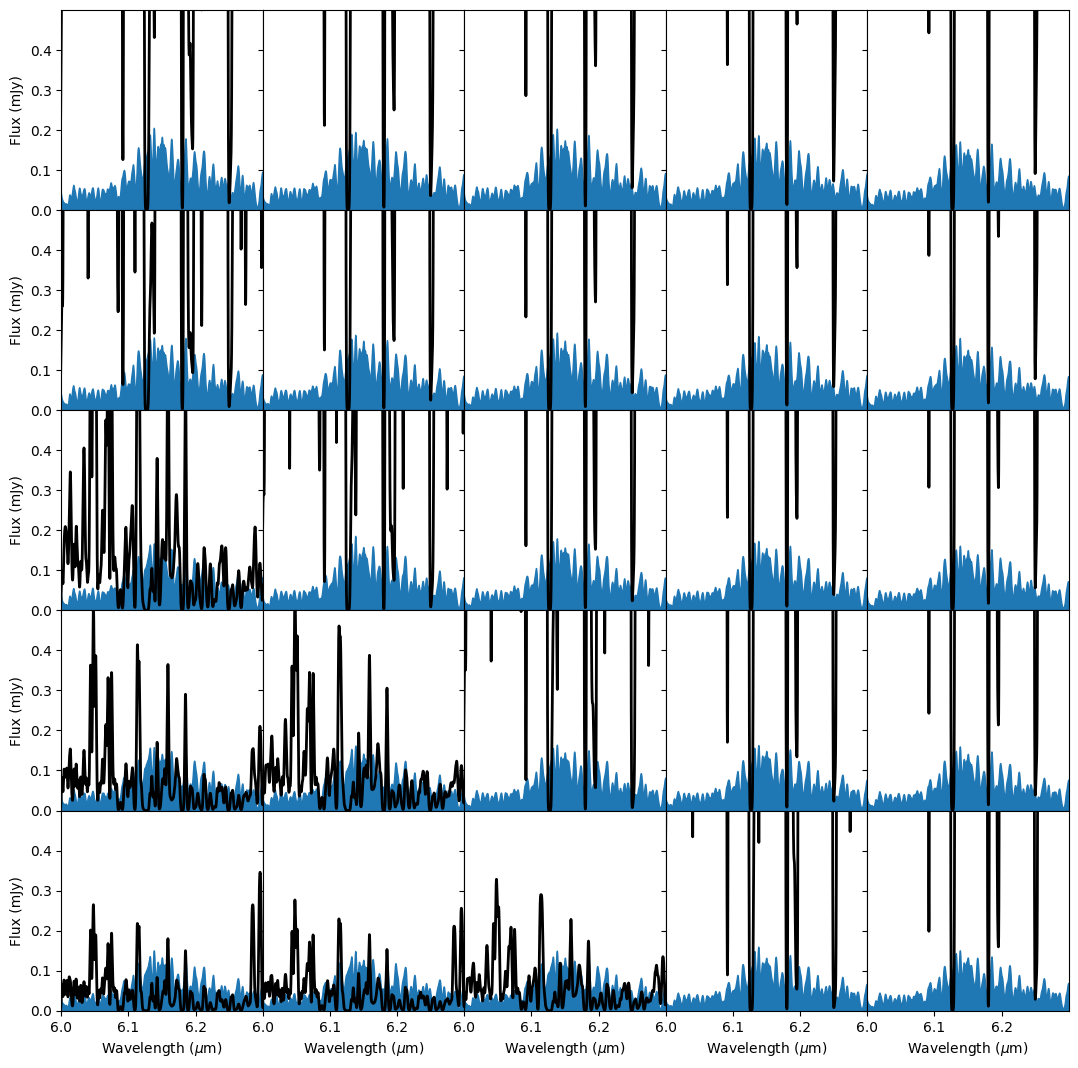

In [7]:
species =['NH3']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[6, 6.3]
yrange=[0,0.5]
num_xticks = 4
num_yticks = 6
total_spec= None
for i, row in df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_flux = row['FLiTs Flux']
    total_wl = row['FLiTs Wavelength']
    for index, specie in enumerate(species):
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_wl = row[f'FLiTs {specie} Wavelength']
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[i].fill_between(specie_wl, 0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(total_wl, total_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

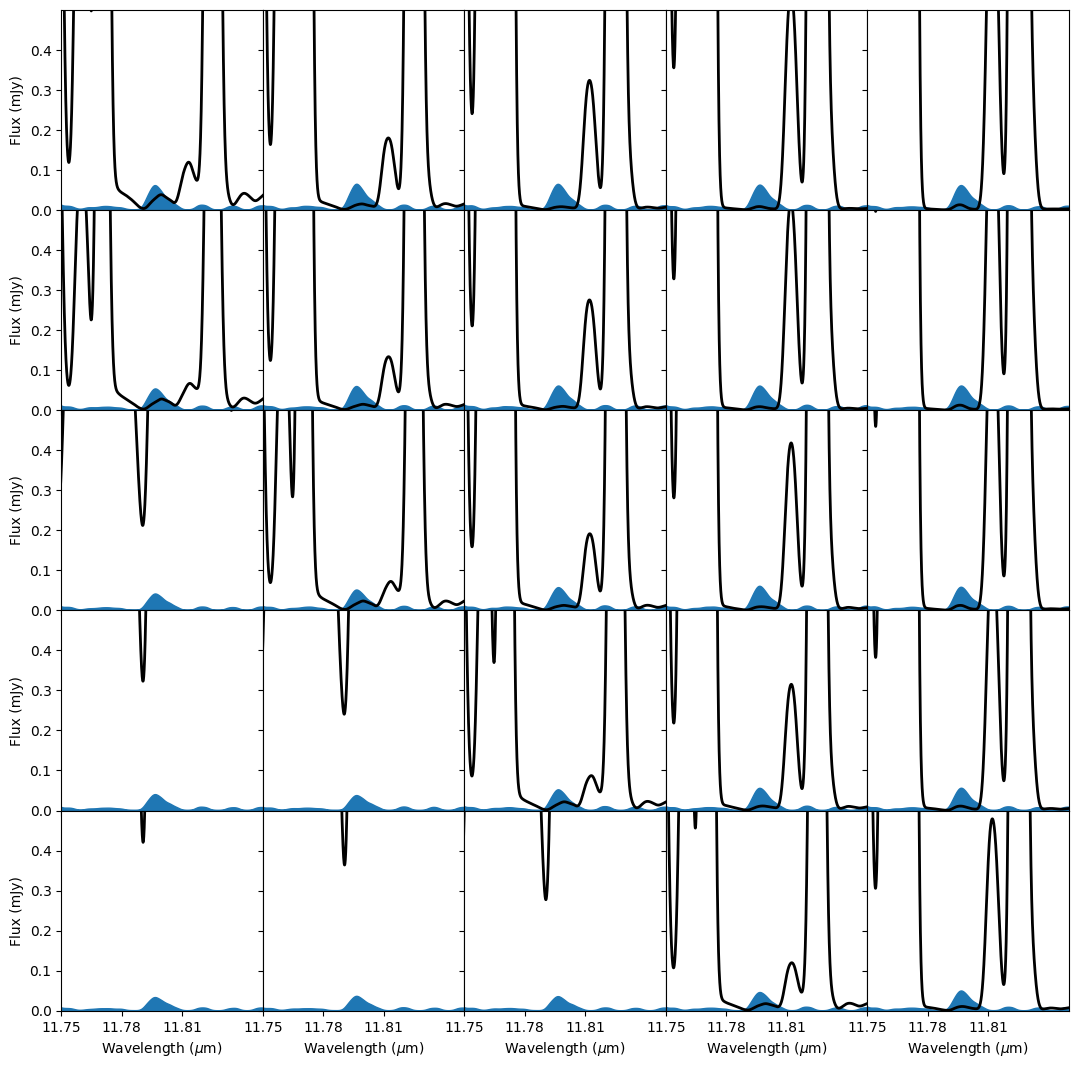

In [8]:
species =['NH3']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[11.75, 11.85]
yrange=[0,0.5]
num_xticks = 4
num_yticks = 6
total_spec= None
for i, row in df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_flux = row['FLiTs Flux']
    total_wl = row['FLiTs Wavelength']
    for index, specie in enumerate(species):
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_wl = row[f'FLiTs {specie} Wavelength']
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[i].fill_between(specie_wl, 0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(total_wl, total_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

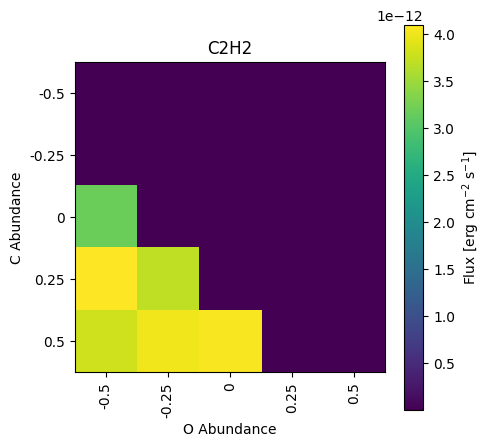

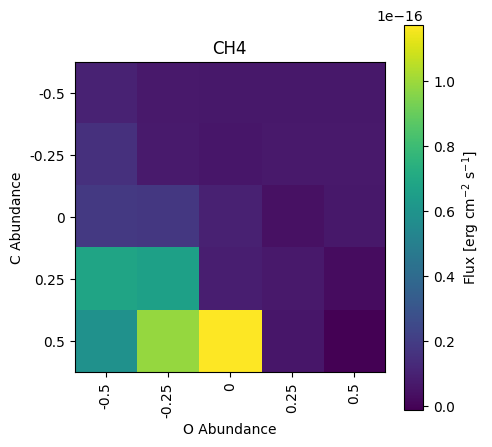

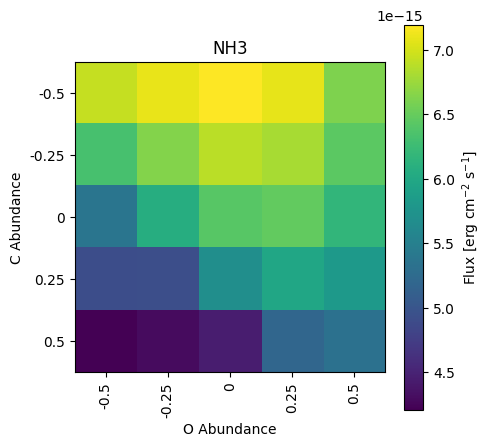

In [9]:
for specie in ['C2H2', 'CH4', 'NH3']:
    plt.figure(figsize=(5, 5))
    plt.imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='viridis')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abundance')
    plt.ylabel('C Abundance')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
    plt.show()

READ: Reading File:  gdr_1000_N/C_0.5_O_-0.5_CO_4.57\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_0.5_O_-0.5_CO_4.57\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 


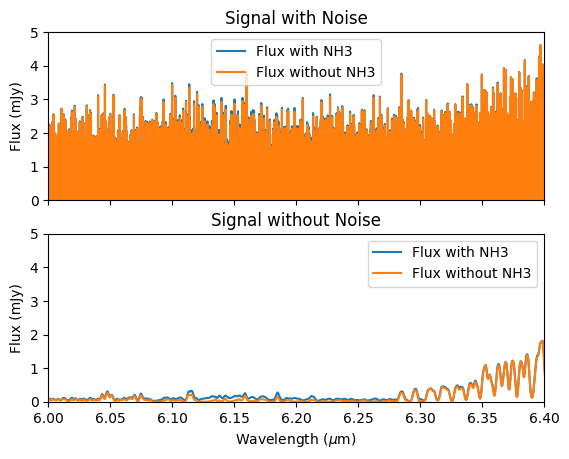

In [10]:
model_index = 20
model_flits = pread.read_FLiTs('gdr_1000_N/' + df['Model Name'][model_index], filename='specFLiTs1.out')
wl, flux_without_NH3, flux_cont = model_flits.convolve(3000, contReturn=True)

NH3_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1_NH3.out')
NH3_wl, NH3_flux, NH3_flux_cont = NH3_flits.convolve(3000, contReturn=True)
NH3_flux = np.interp(wl, NH3_wl, NH3_flux)
NH3_flux_cont = np.interp(wl, NH3_wl, NH3_flux_cont)
flux_with_NH3 = flux_without_NH3 + NH3_flux - NH3_flux_cont

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

np.random.seed(42)
noise_flux = add_noise(flux_with_NH3, 300)
ax1.plot(wl, (noise_flux - flux_cont) * 1000, label='Flux with NH3')

np.random.seed(42)
noise_flux = add_noise(flux_without_NH3, 300)
ax1.plot(wl, (noise_flux - flux_cont) * 1000, label='Flux without NH3')

ax1.set_title('Signal with Noise')
ax1.set_ylabel('Flux (mJy)')
ax1.set_xlim(6, 6.4)
ax1.set_ylim(0, 5)
ax1.legend()

ax2.plot(wl, (flux_with_NH3 - flux_cont) * 1000, label='Flux with NH3')
ax2.plot(wl, (flux_without_NH3 - flux_cont) * 1000, label='Flux without NH3')
ax2.set_title('Signal without Noise')
ax2.set_xlabel(r'Wavelength ($\mu$m)')
ax2.set_ylabel('Flux (mJy)')
ax2.legend()
plt.show()

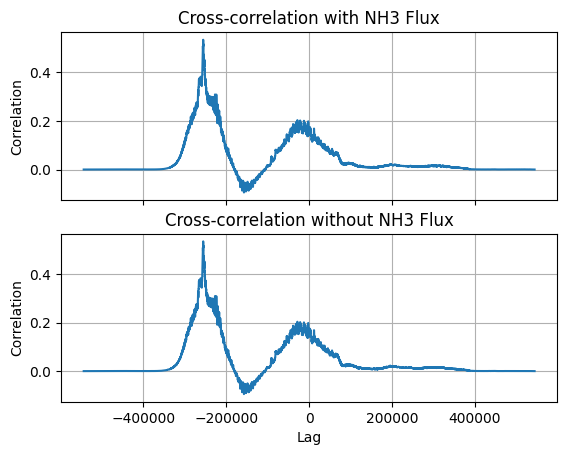

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

np.random.seed(42)
noise_flux = add_noise(flux_with_NH3, 300)
cc1 = fftconvolve((NH3_flux - NH3_flux_cont), (noise_flux - flux_cont)[::-1], mode='full')
lags = np.arange(-len(noise_flux)+1, len(NH3_flux))
ax1.plot(lags, cc1)
ax1.set_title("Cross-correlation with NH3 Flux")
ax1.set_ylabel("Correlation")
ax1.grid(True)


np.random.seed(42)
noise_flux = add_noise(flux_without_NH3, 300)
cc2 = fftconvolve((NH3_flux - NH3_flux_cont), (noise_flux - flux_cont)[::-1], mode='full')
lags = np.arange(-len(noise_flux)+1, len(NH3_flux))
ax2.plot(lags, cc2)
ax2.set_title("Cross-correlation without NH3 Flux")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Correlation")
ax2.grid(True)
plt.show()

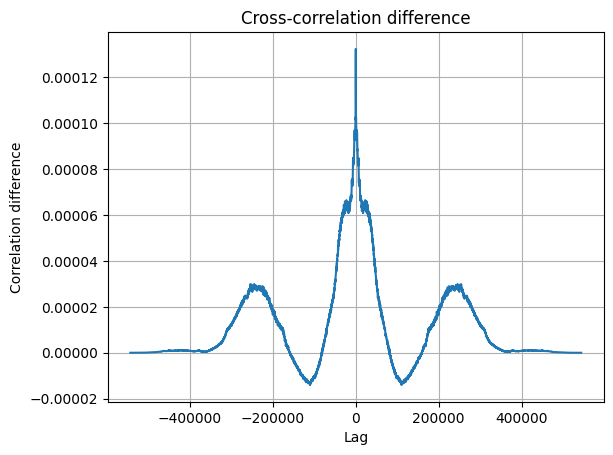

In [12]:
# Plotting the difference between the crosscorrelations
plt.plot(lags, cc1-cc2)
plt.title("Cross-correlation difference")
plt.xlabel("Lag")
plt.ylabel("Correlation difference")
plt.grid(True)
plt.show()

In [13]:
# Making all the arrays on a uniform wavelength grid
wl_uniform = np.linspace(min(wl), max(wl), len(wl))
flux_without_NH3_uniform = np.interp(wl_uniform, wl, flux_without_NH3)
flux_with_NH3_uniform = np.interp(wl_uniform, wl, flux_with_NH3)
flux_cont_uniform = np.interp(wl_uniform, wl, flux_cont)
np.random.seed(42)
noise_flux_with_NH3_uniform = add_noise(flux_with_NH3_uniform, 300)
NH3_flux_uniform = np.interp(wl_uniform, wl, NH3_flux)
NH3_flux_cont_uniform = np.interp(wl_uniform, wl, NH3_flux_cont)
np.random.seed(42)
noise_flux_without_NH3_uniform = add_noise(flux_without_NH3_uniform, 300)

NH3_flux_uniform -= NH3_flux_cont_uniform
noise_flux_with_NH3_uniform -= flux_cont_uniform
noise_flux_without_NH3_uniform -= flux_cont_uniform

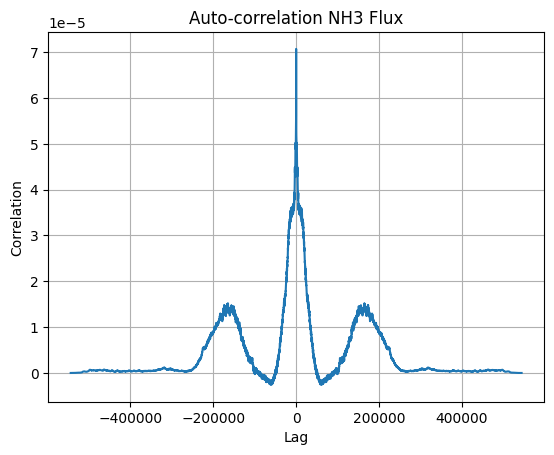

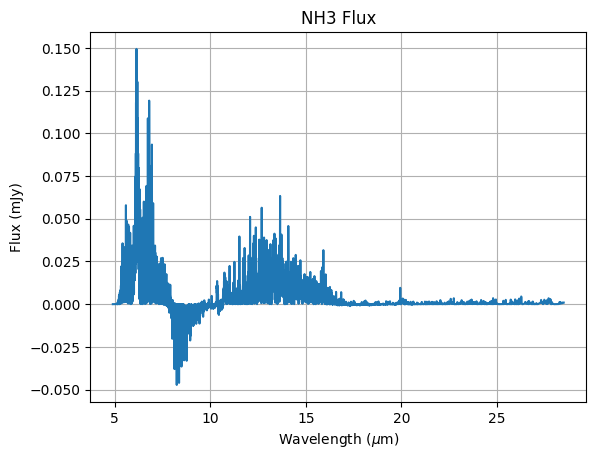

In [14]:
ac = fftconvolve(NH3_flux_uniform, NH3_flux_uniform[::-1], mode='full')
lags = np.arange(-len(NH3_flux_uniform)+1, len(NH3_flux_uniform))

# Plotting the autocorrelation of NH3
plt.plot(lags, ac)
plt.title('Auto-correlation NH3 Flux')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()

# Plotting NH3
plt.plot(wl_uniform, NH3_flux_uniform*1000)
plt.title("NH3 Flux")
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (mJy)')
plt.grid(True)
plt.show()

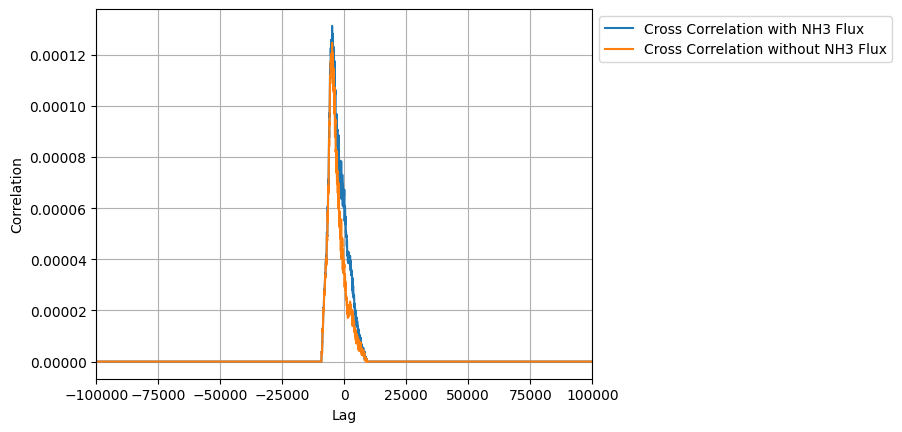

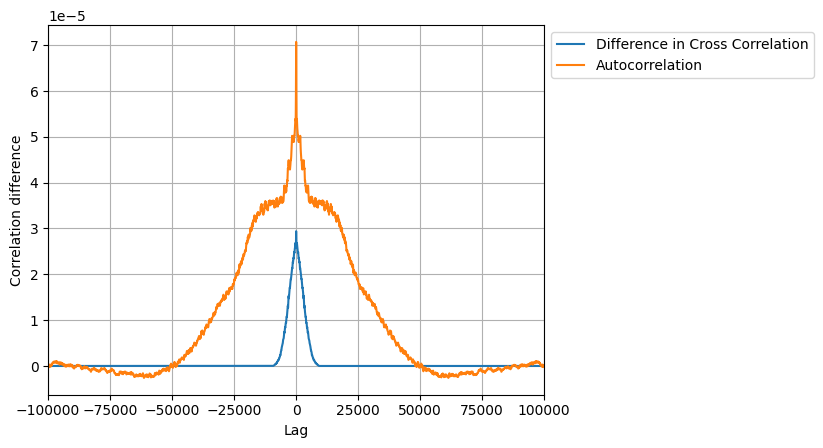

In [15]:
new_noise_flux = noise_flux_with_NH3_uniform.copy()
new_NH3_flux = NH3_flux_uniform.copy()
new_noise_wout_NH3_flux = noise_flux_without_NH3_uniform.copy()

wl_mask = (wl_uniform < 6) | (wl_uniform > 6.4)
flux_treshold = 0.1

# Masking the array
new_noise_flux[wl_mask] = 0
new_noise_flux[new_noise_flux>flux_treshold] = 0
new_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

# Calculating the crosscorrelation
cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')

# Comparing the crosscorrelations for the signals with and without NH3
plt.plot(lags, cc_with, label='Cross Correlation with NH3 Flux')
plt.plot(lags, cc_without, label='Cross Correlation without NH3 Flux')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(-100000, 100000)
plt.show()

# Comparing the difference and the autocorrelation
plt.plot(lags, cc_with - cc_without, label='Difference in Cross Correlation')
plt.plot(lags, ac, label='Autocorrelation')
plt.xlabel("Lag")
plt.ylabel("Correlation difference")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(-100000, 100000)
plt.show()

In [16]:
def difference(params):
    a,b,c = params
    new_noise_flux = noise_flux_with_NH3_uniform.copy()
    new_NH3_flux = NH3_flux_uniform.copy()
    new_noise_wout_NH3_flux = noise_flux_without_NH3_uniform.copy()

    wl_mask = (wl_uniform < a) | (wl_uniform > b)
    flux_treshold = c

    new_noise_flux[wl_mask] = 0
    new_noise_flux[new_noise_flux>flux_treshold] = 0
    new_NH3_flux[wl_mask] = 0
    # new_NH3_flux[new_NH3_flux>flux_treshold] = 0
    new_noise_wout_NH3_flux[wl_mask] = 0
    new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

    cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
    cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')
    return -abs(cc_with[lags==0]-cc_without[lags==0])/abs(b-a+1)

initial_guess = [6, 6.4, 0.1]

result = minimize(difference, initial_guess, method='Nelder-Mead')

best_params = result.x

[6.0450756  6.3024475  0.10686546]


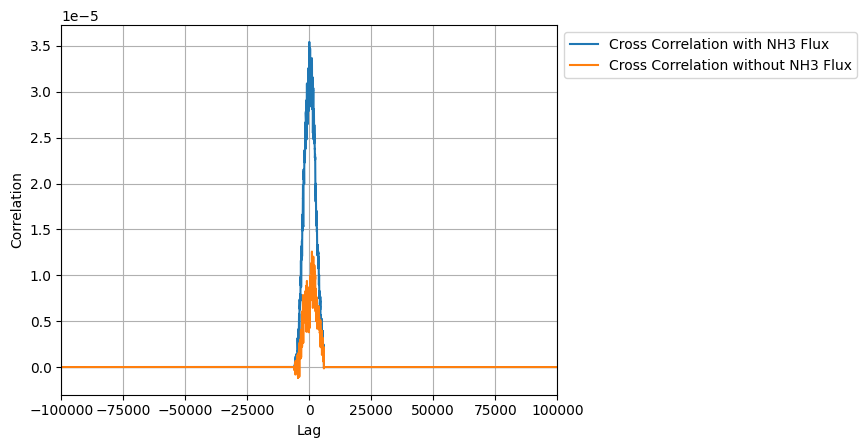

In [17]:
print(best_params)
new_noise_flux = noise_flux_with_NH3_uniform.copy()
new_NH3_flux = NH3_flux_uniform.copy()
new_noise_wout_NH3_flux = noise_flux_without_NH3_uniform.copy()

wl_mask = (wl_uniform < best_params[0]) | (wl_uniform > best_params[1])
flux_treshold = best_params[2]

new_noise_flux[wl_mask] = 0
new_noise_flux[new_noise_flux>flux_treshold] = 0
new_NH3_flux[wl_mask] = 0
# new_NH3_flux[new_NH3_flux>flux_treshold] = 0
new_noise_wout_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')
# Comparing the crosscorrelations for the signals with and without NH3
plt.plot(lags, cc_with, label='Cross Correlation with NH3 Flux')
plt.plot(lags, cc_without, label='Cross Correlation without NH3 Flux')
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlim(-100000, 100000)
plt.show()

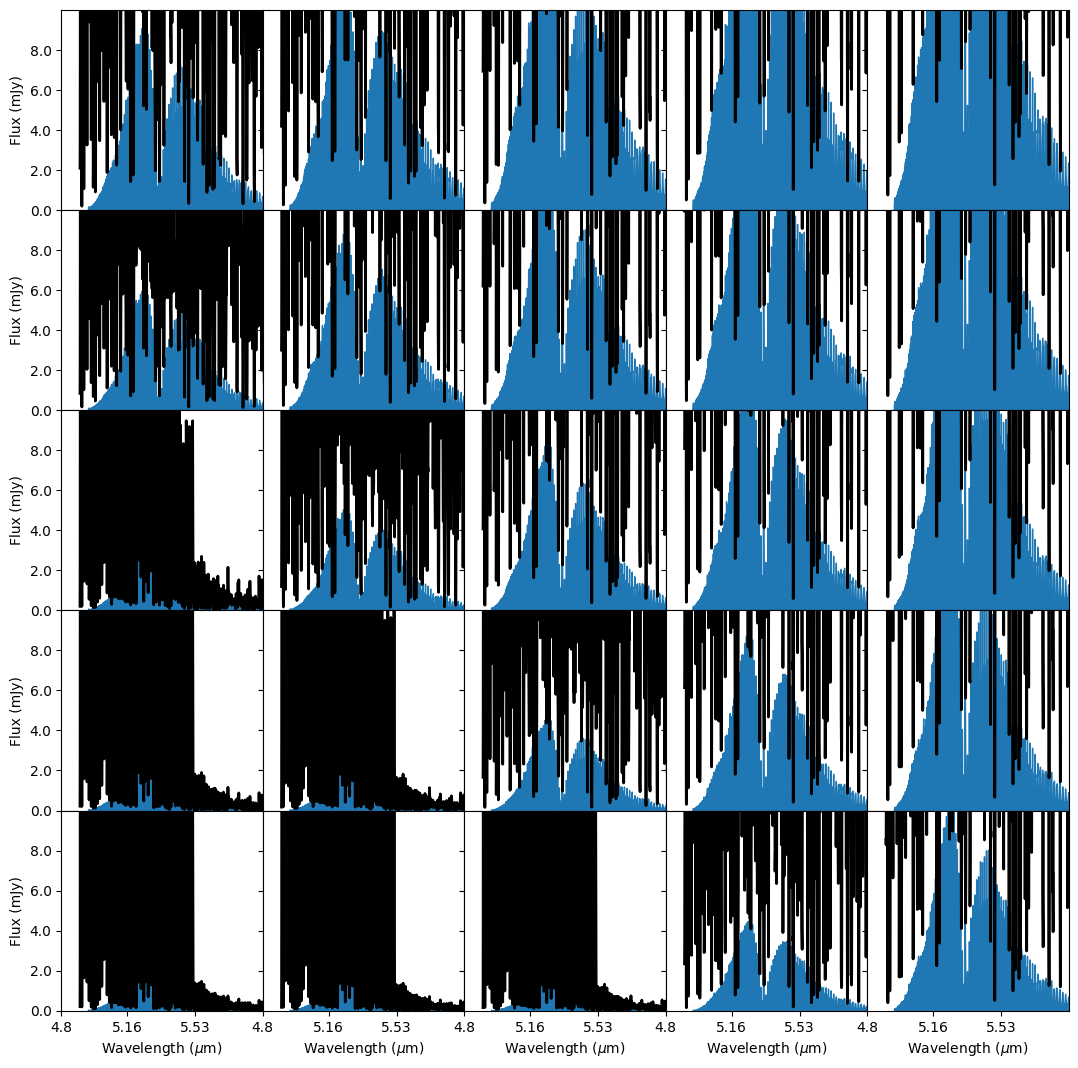

In [18]:
species =['NO']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[4.8, 5.9]
yrange=[0,10]
num_xticks = 4
num_yticks = 6
total_spec= None
for i, row in df.iterrows():
    n_row, n_col = divmod(i, 5)
    total_flux = row['FLiTs Flux']
    total_wl = row['FLiTs Wavelength']
    for index, specie in enumerate(species):
        specie_flux = row[f'FLiTs {specie} Flux']
        specie_wl = row[f'FLiTs {specie} Wavelength']
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[i].fill_between(specie_wl, 0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(total_wl, total_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

In [21]:
gdr = '1000'
with open(f'FLiTsData{gdr}.pkl', 'rb') as f:
    df = pickle.load(f)
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


Max line height
    H2O 4.64924034398089e-12
    CO 6.812713644300617e-13
    NO 1.3583139652913537e-13
    CH4 8.78398771280297e-17
    NH3 3.3807569385100874e-15


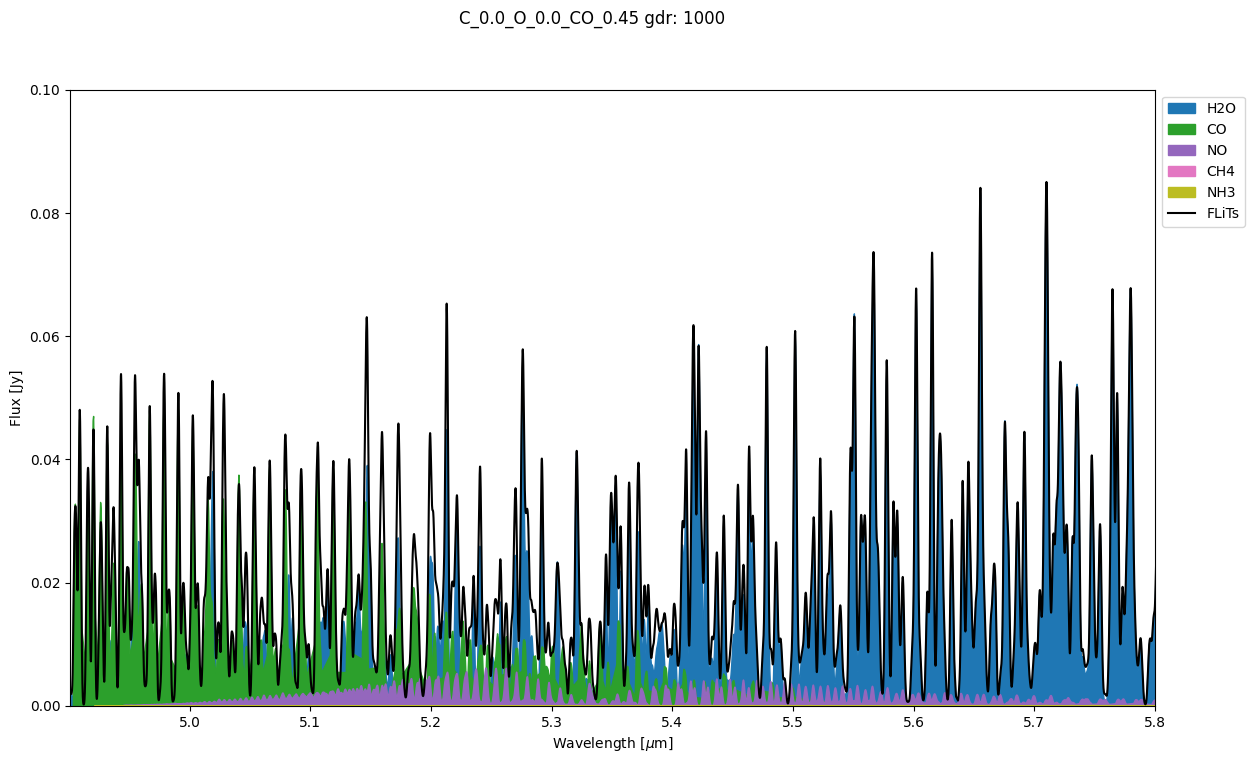

In [22]:
cmap = mpl.colormaps.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(14, 8))
species = ['H2O','CO','NO', 'CH4', 'NH3']
model = df['Model Name'][12]
print('Max line height')
for index, specie in enumerate(species):
    ax.fill_between(df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy(), 0, df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy(), label=specie, zorder=index,
                    color=cmap(index / len(species)))
    print('   ',specie, total_flux(df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy(), df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()))
ax.plot(df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy(),
        df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy(), label='FLiTs', color='black',
        zorder=20)
fig.suptitle(model+' gdr: '+gdr[:4]+' ')
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim([4.901, 5.8])
ax.set_ylim(0,0.1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [79]:
print(1.3583139652913537e-13/(3.3807569385100874e-15))

40.17780603564975


In [23]:
with open('ProDiMoData1000.pkl', 'rb') as f:
    models = pickle.load(f)

[['NO_H', 5.22197342]]
PLOT: plot_cont ...


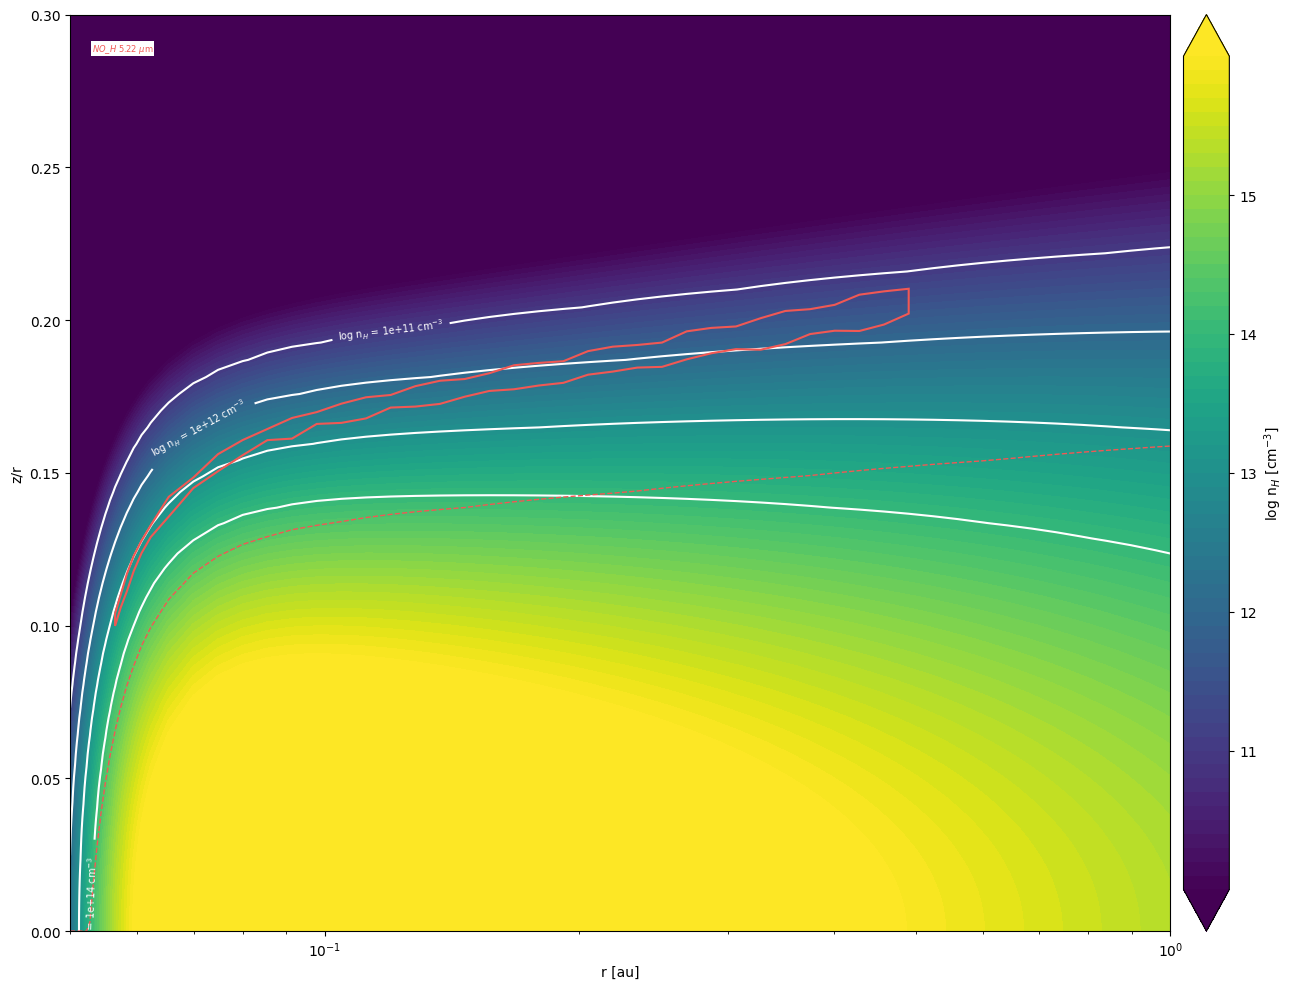

In [70]:
fig, ax = plt.subplots(figsize=(14, 10))
for i, model in enumerate(models):
    if i != 12:
        continue
    lines=model.selectLineEstimates(ident="NO_H",wlrange=[4.9,28])
    lines=sorted(lines,key=lambda x: x.flux,reverse=True)[:1]
    line_ident = [['NO_H', x.wl] for x in lines]
    print(line_ident)
    # print(type(lines[0]))
    # lines=sorted(lines,key=lambda x: x.flux,reverse=True)[:50]
    # mask = model.getLineOriginMask(lines)
    pp=pplot.Plot(None)
    cont=pplot.Contour(model.nHtot,[1e11, 1e12, 1e13, 1e14],label_fmt=r"log n$_{H}$ = %.0e cm$^{-3}$",colors="white",linestyles="-",showlabels=True)
    # cbticks = [10, 30, 100, 300, 1000]
    fig=pp.plot_line_origin(model,line_ident,field=model.nHtot ,
                            label=r"log n$_{H}$ [cm$^{-3}$]",extend="both",cb_format="%.0f",zr=True,xlog=True, zlim=[1e10, 1e16],
                            xlim=[None,1],ylim=[None,0.3], showcb=True,
                            showContOrigin=False,showRadialLines=False, ax=ax,  oconts=[cont]) # this adds an additional contour
    # fig=pp.plot_abuncont(model, species='NO', contour=False,ax=ax, xlim=[None,1])
    plt.tight_layout()
plt.show()
    # print(*waterlines, sep="\n")